In [1]:
# TensorFlow 라이브러리 불러오기

import tensorflow as tf

tf.__version__

'1.3.0'

In [2]:
# NumPy 라이브러리 불러오기

import numpy as np

np.__version__

'1.13.1'

In [3]:
# Matplotlib 라이브러리 불러오기

import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'2.0.2'

In [4]:
# MNIST 데이터 로딩

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/mnist-data')

Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz


In [5]:
# 훈련 데이터 확인

mnist.train.images.shape, mnist.train.labels.shape

((55000, 784), (55000,))

In [6]:
# 테스트 데이터 확인

mnist.test.images.shape, mnist.test.labels.shape

((10000, 784), (10000,))

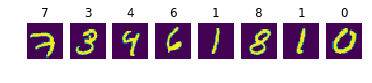

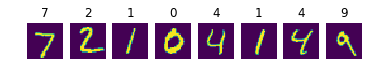

In [7]:
# 손글씨 이미지 시각화

def draw_image(images, labels):
    fig, axes = plt.subplots(1, images.shape[0])
    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(images[i].reshape(28, 28))
        ax.set_title(labels[i])
    plt.show()

draw_image(mnist.train.images[:8],
           mnist.train.labels[:8])

draw_image(mnist.test.images[:8],
           mnist.test.labels[:8])

In [8]:
# 신경망 모델 생성

# 데이터

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int64, [None])

# 입력 노드: 28 * 28개 / 출력 노드: 10개

w = tf.Variable(tf.truncated_normal([28 * 28, 10], stddev=0.1))
b = tf.Variable(tf.truncated_normal([10], stddev=0.1))

# f( W * x + b )

u = tf.matmul(x, w) + b
z = tf.nn.softmax(u)

In [9]:
# 손실/비용 함수

loss = tf.nn.softmax_cross_entropy_with_logits(
    logits=u, # softmax 적용하지 않은 값
    labels=tf.one_hot(y, 10)
)

# 최적화

learning_rate = 0.3
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [10]:
# 예측

predict = tf.argmax(z, axis=1)

# 정확도

correct = tf.equal(y, predict)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
# TensorFlow 세션 준비

session = tf.Session()
session.run(tf.global_variables_initializer())

In [12]:
# 정확도 출력

test_feed = {
    x: mnist.test.images,
    y: mnist.test.labels
}

def print_accuracy(index):
    print('{} - {}'.format(index, session.run(accuracy, feed_dict=test_feed)))

In [13]:
# 훈련

print_accuracy(0)

for i in range(20):
    for j in range(100):
        x_data, y_data = mnist.train.next_batch(200)
        train_feed = {
            x: x_data,
            y: y_data
        }
        session.run(train, feed_dict=train_feed)
    print_accuracy(i + 1)

print('Done!')

0 - 0.09589999914169312
1 - 0.8393999934196472
2 - 0.8766999840736389
3 - 0.8076000213623047
4 - 0.892799973487854
5 - 0.9017999768257141
6 - 0.8927000164985657
7 - 0.8513000011444092
8 - 0.9078999757766724
9 - 0.892799973487854
10 - 0.8963000178337097
11 - 0.8755000233650208
12 - 0.8393999934196472
13 - 0.8780999779701233
14 - 0.9107999801635742
15 - 0.7843000292778015
16 - 0.9120000004768372
17 - 0.8652999997138977
18 - 0.868399977684021
19 - 0.9078999757766724
20 - 0.9120000004768372
Done!


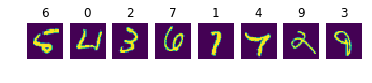

In [14]:
# 오답 시각화

c, p = session.run([correct, predict], feed_dict=test_feed)

images = mnist.test.images[~c]
labels = p[~c]

draw_image(images[:8], labels[:8])

In [15]:
# TensorFlow 그래프 초기화

tf.reset_default_graph()

In [16]:
# CNN 모델 생성

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int64, [None])

x_2d = tf.reshape(x, [-1, 28, 28, 1])

print('입력', x_2d.shape)

# 1단계 -> 4채널 14 * 14

c1 = tf.contrib.layers.conv2d(x_2d, 4, [5, 5])
p1 = tf.contrib.layers.max_pool2d(c1, [2, 2])

print('1단계', p1.shape)

# 2단계 -> 8채널 7 * 7

c2 = tf.contrib.layers.conv2d(p1, 8, [5, 5])
p2 = tf.contrib.layers.max_pool2d(c2, [2, 2])

print('2단계', p2.shape)

# Flat -> 7 * 7 * 8

flat = tf.contrib.layers.flatten(p2)

print('모두 연결', flat.shape)

# 중간층 -> 출력 노드: 200개

hidden = tf.contrib.layers.fully_connected(flat, 200)

print('중간', hidden.shape)

# 출력 노드: 10개

u = tf.layers.dense(hidden, 10)
z = tf.nn.softmax(u)

print('출력', z.shape)

입력 (?, 28, 28, 1)
1단계 (?, 14, 14, 4)
2단계 (?, 7, 7, 8)
모두 연결 (?, 392)
중간 (?, 200)
출력 (?, 10)


In [17]:
# 손실/비용 함수

loss = tf.nn.softmax_cross_entropy_with_logits(
    logits=u, # softmax 적용하지 않은 값
    labels=tf.one_hot(y, 10)
)

# 최적화 - Adam algorithm

learning_rate = 0.0001
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# 예측

predict = tf.argmax(z, axis=1)

# 정확도

correct = tf.equal(y, predict)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
# TensorFlow 세션 준비

session = tf.Session()
session.run(tf.global_variables_initializer())

# 정확도 출력

test_feed = {
    x: mnist.test.images,
    y: mnist.test.labels
}

def print_accuracy(index):
    print('{} - {}'.format(index, session.run(accuracy, feed_dict=test_feed)))

In [19]:
# 훈련

print_accuracy(0)

for i in range(20):
    for j in range(100):
        x_data, y_data = mnist.train.next_batch(200)
        train_feed = {
            x: x_data,
            y: y_data
        }
        session.run(train, feed_dict=train_feed)
    print_accuracy(i + 1)

print('Done!')

0 - 0.09780000150203705
1 - 0.6018999814987183
2 - 0.7594000101089478
3 - 0.8205999732017517
4 - 0.8619999885559082
5 - 0.8748000264167786
6 - 0.8848999738693237
7 - 0.8948000073432922
8 - 0.8986999988555908
9 - 0.906499981880188
10 - 0.9114999771118164
11 - 0.9132000207901001
12 - 0.914900004863739
13 - 0.9207000136375427
14 - 0.9254999756813049
15 - 0.926800012588501
16 - 0.9287999868392944
17 - 0.9319000244140625
18 - 0.9340000152587891
19 - 0.9365000128746033
20 - 0.9397000074386597
Done!


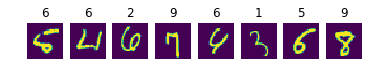

In [20]:
# 오답 시각화

c, p = session.run([correct, predict], feed_dict=test_feed)

images = mnist.test.images[~c]
labels = p[~c]

draw_image(images[:8], labels[:8])